<!-- KODE = "ja", "nei", default "ja" -->


<!-- dom:TITLE: Numerical solution of ordinary differential equations: High order Runge-Kutta methods -->
# Numerical solution of ordinary differential equations: Stiff Problems
<!-- dom:AUTHOR: Alvar Wallström Lindell -->
<!-- Author: -->  
**Alvar Wallström Lindell**

Date: **March 23, 2021**

If you want to have a nicer theme for your jupyter notebook,
download the [cascade stylesheet file tma4125.css](https://www.math.ntnu.no/emner/TMA4125/2020v/part_II/notebooks/tma4125.css)
and execute the next cell:

In [1]:
from IPython.core.display import HTML
def css_styling():
    try:
        with open("tma4125.css", "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        pass #Do nothing

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

In this notebook we will demonstrate the problems that arise when one solves stiff problems. Recall that an example of a stiff problem is the linear test equation
$$
    y'(t) = \lambda y(t)
$$
where $\lambda<<0,$ for example $\lambda = -10^4$. We start by importing important modules. The modulke $\texttt{ode}$ comes from the file $\texttt{ode.py}$. This file needs to be placed in the same directory as this notebook.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ode

We start by writing a simple solver for the linear test equation. We do not specify what $\texttt{method}$ we use for time-stepping, but for simplicity we assume that it takes in $y\lambda, y_0$ and $h$ as parameters and returns $y_1$. Our function $\texttt{solve_lintest}$ returns a list of numerical solutions 
$$\{y_n,\quad n=0,...,N\}$$ along with the time steps $$\{t_n,\quad n=0,...,N\}.$$

In [3]:
def solve_lintest(lam,t0,T,y0,h,method):
    YY = [y0]
    TT = [t0]
    
    t = t0
    y = y0
    
    while t<T-h/2:
        y = method(lam,y,h)
        t += h
        YY.append(y)
        TT.append(t)
        
    return YY,TT

We start by attempting to solve the problem with $y_0 = 1$ and $t \in [0,1]$. We use the simplest method, the Explicit Euler (sometimes called Forward Euler) method.

In [4]:
def explicit_euler(lam,y0,h):
    ynew = y0 + h*lam*y0
    return ynew

We solve the problem for $\lambda = -10^2$ with three different step sizes: $h \in \{1\cdot 10^{-2}, 2\cdot 10^{-2}, 3 \cdot 10^{-2}\}$.

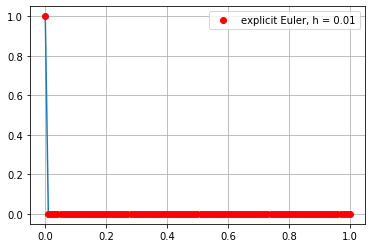

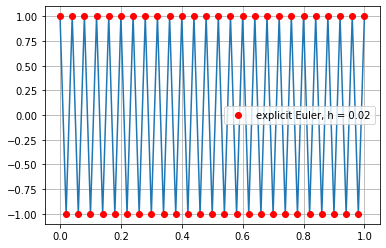

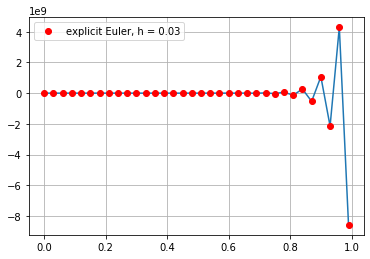

In [5]:
t0 = 0
T = 1
y0 = 1

lam = -100 #lambda-parameter in linear test equation

for h in [1.e-2,2.e-2,3.e-2]:
    
    plt.figure()
    YY,TT = solve_lintest(lam,t0,T,y0,h,explicit_euler)
    plt.plot(TT,YY)
    plt.plot(TT,YY,'ro', label = "explicit Euler, h = "+str(h))
    plt.legend()

We notice that the behaviour is very different for the different values of $h$. For $h = 10^{-2}$ we see that the numerical solution quickly becomes tiny, something we expect since the exact solution is $y_{ex}(t) = e^{-100t}$. For $h = 2\cdot 10^{-2}$ the numerical solution seems to oscillate quickly, without ever becoming smaller or larger (in absolute value). Finally, for $h = 3\cdot 10^{-3}$ we see that the solution "explodes", reaching values is the billions. It seems that we need a very small step size, in order to properly solve the problem. This is bad, since that can take a long time. Try it out with $\lambda = -10^5$ and $h \in \{1\cdot 10^{-5}, 2\cdot 10^{-5}, 3\cdot 10^{-5}\}$. You will see that to solve the problem with explicit Euler method we require $h \leq 2/|\lambda|$ in order for the solution not to blow up.

But perhaps we can avoid small step sizes by using adaptive step sizes? After all, the exact solution does not change much after a few steps. We use the embedded RK-method Explicit-Euler/Heun and try it out. We plot the step-sizes as a function of time.

Step is rejected at t = 0.1532050371663907 with err = 0.0012358546786898875
Finishing time-stepping reaching t = 1.0112916594335868 with final time T = 1
Used 110 steps out of 100000.0 with 1 being rejected


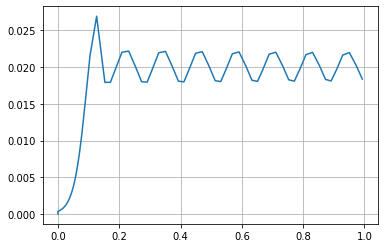

In [6]:
#Sets up the method using already defined Embedded RKM-class
eh = ode.embedded_rkm_tables['euler_heun']
eh_method = ode.EmbeddedExplicitRungeKutta(eh['a'], eh['b'], eh['c'], bhat = eh['bhat'], order = eh['order'])

y0 = 1
t0 = 0
T = 1
lam = -1.e2
f = lambda t,y:lam*y
Nmax = 1e5

ts, ys = eh_method(y0,t0,T,f,Nmax)

#Find step sizes
h_list = np.diff(ts)
plt.plot(ts[:-1],h_list)

We see that the necessary step size (with tolerance $\texttt{tol} = 10^{-3}$) is still around $2\cdot 10^{-2} = 2/|\lambda|.$ Hence, adaptive step sizes is not the answer, they still need to be very small.

But what if we try the Implicit Euler method (sometimes called Backwards Euler method)? Normally we then need to solve a nonlinear equation, but since the test equation is linear, we can implement it quite easily. We try it out with $h = 0.2$, a step size which would definitely not work for the Explicit Euler method.

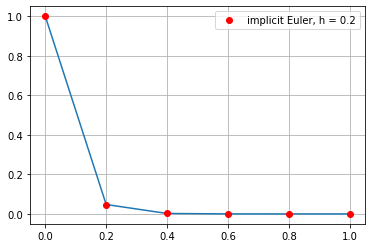

In [7]:
t0 = 0
T = 1
y0 = 1

lam = -100

h = 0.2

def implicit_euler(lam,y0,h):
    ynew = y0/(1-h*lam)
    return ynew

plt.figure() 



YY,TT = solve_lintest(lam,t0,T,y0,h,implicit_euler)
plt.plot(TT,YY)
plt.plot(TT,YY,'ro', label = "implicit Euler, h = "+str(h))
plt.legend()

It works! But why does it work for Implicit Euler, but not Explicit Euler? We need to study the *stability properties* of the functions, see the notes.

**Read the notes**

Now that we understant the concepts of stability function and stability region we would like to investigate them. Finding the stability function is straight forward, but finding the stability region can be hard, especially since it is in $\mathbb{C}$. Luckily, we can plot it fairly easily using the code below. 

In [10]:
def plot_R(R,Xax,Yax, title = None):
    
    #Plots the area in the complex plane 0 <= |R(z)| <= 1. Thet real line is Xax and the imaginary
    #line is Yax. These should be lists or 1D-arrays of values.
    
    X,Y = np.meshgrid(Xax,Yax)
    
    xsize = max(Xax)-min(Xax)
    ysize = max(Yax)-min(Yax)
    
    maxsize = max(xsize,ysize)
    scale = 6/maxsize
    
    plt.figure(figsize = (xsize*scale,ysize*scale))
    
    plt.contourf(X,Y,abs(R(X,Y)), 1, levels = [0,1])
    plt.contour(X,Y,abs(R(X,Y)), 1, colors = 'black', levels = [1])

    plt.plot([0,0],[min(Yax),max(Yax)], 'k--')
    plt.grid()
    
    if title != None:
        plt.title(title)
        
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')

The code requires that you have calculated $R$ as a function of $x = Re(z)$ and $y = Im(z)$. For example, the in order to see the stability region for the Explicit Euler method we note that the stability function is 
$$
    R_{ee}(z) = 1 + z.
$$
Rewriting with $z = x + iy$ we get
$$
    R_{ee}(x,y) = 1 + x + iy.
$$
We can now plot the stability region.

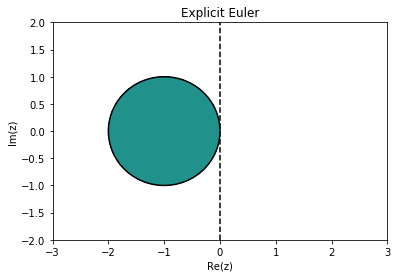

In [11]:
Xax = np.linspace(-3,3,101)
Yax = np.linspace(-2,2,101)

R_ee = lambda x,y: 1+x+y*1j #Stability function for Explicit Euler
plot_R(R_ee, Xax, Yax, title = 'Explicit Euler')

We can now see why the numerical solutions exploded! We see that we need $-2 \leq h\lambda \leq 0$ in order for it to not explode.

Down below we have plotted the stability region for the implicit Euler method.

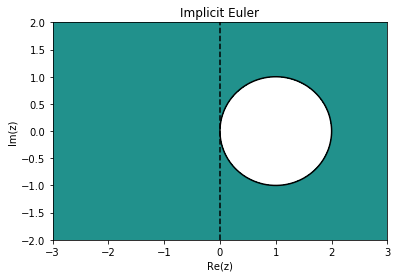

In [12]:
R_ie = lambda x,y: 1/(1-(x+y*1j)) #Implicit Euler
plot_R(R_ie, Xax, Yax, title = 'Implicit Euler')

We can also plot the regions for Crank-Nicolson and Heun's method.

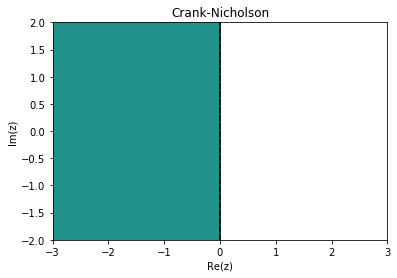

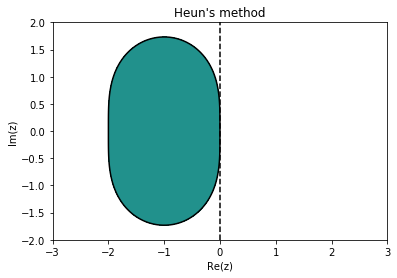

In [13]:
R_cn = lambda x,y: (1+0.5*(x+y*1j))/(1-0.5*(x+y*1j)) #Crank-Nicolson/Trapezoidal Method
R_hn = lambda x,y: 1 + (x+y*1j) + 0.5*(x+y*1j)**2 #Heun's method



Xax = np.linspace(-3,3,101)
Yax = np.linspace(-2,2,101)


plot_R(R_cn, Xax, Yax, title = 'Crank-Nicholson')
plot_R(R_hn, Xax, Yax, title = 'Heun\'s method')

Finally, below we have written a code to plot the stability region for the $\theta$-method. Try it around with different $\theta$. You can see that the method is A-stable for $\theta \geq 1/2$.

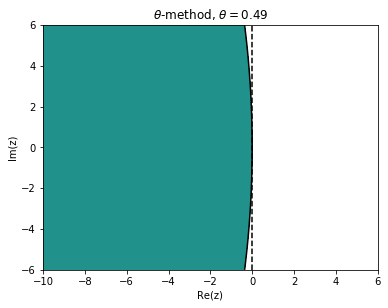

In [14]:
theta = 0.49
X_wide = np.linspace(-10,6,101)

Y_wide = np.linspace(-6,6,101)

R_theta = lambda x,y: (1+(1-theta)*(x+y*1j))/(1-theta*(x+y*1j))

plot_R(R_theta, X_wide, Y_wide, title = r'$\theta$-method, $\theta = {:.2f}$'.format(theta))